In [2]:
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn import svm
from scipy.stats import poisson, binom
from cpp.optimize_price import PriceOptimizer as PriceOptimizer_CPP
from python.optimize_price import PriceOptimizer as PriceOptimizer_Python
import time

In [49]:
# Generate training data for sales probability regression
def rank(a, p):
    _rank = p.shape[0]
    for i in range(p.shape[0]):
        if a < p[i]:
            _rank = _rank - 1
    return _rank

def make_X(price, competitor_prices, t):
    return np.array([
            rank(price, competitor_prices),
            price - competitor_prices.min(),
            price,
            t,
            t * t,
            t * rank(price, competitor_prices),
            np.sqrt(t)
        ])

def generate_train_data(B=500, T=100):
    our_price = np.around(10 + np.random.uniform(0, 10, (B * T, 1)), decimals=2)
    competitor_prices = np.around(10 + np.random.uniform(0, 10, (B * T, 3)), decimals=2)
    
    X = np.zeros((B * T, 7))
    Y = np.zeros(B * T)
    for t in range(T):
        for i in range(B):
            index = t * B + i
            X[index,:] = make_X(our_price[index], competitor_prices[index], t)
            _rank = rank(our_price[index], competitor_prices[index])
            Y[index] = (5 * t / T + 2 * (competitor_prices.shape[1] - _rank - 1)) * np.random.uniform(0, 1)

    return (X, Y)

X, Y = generate_train_data()

In [50]:
# Train sales probability model
def make_model(X, Y):
    regr = linear_model.LinearRegression()
    regr.fit(X, Y)
    coef = np.concatenate((regr.intercept_.ravel(), regr.coef_.ravel()))
    def predict(x):
        x = np.hstack((np.ones((x.shape[0], 1)), x))
        return np.maximum(0, np.dot(x, coef))
        # return regr.predict_proba(x)[:, 1]
    return predict, coef

sales_model, sales_model_coef = make_model(X, Y)

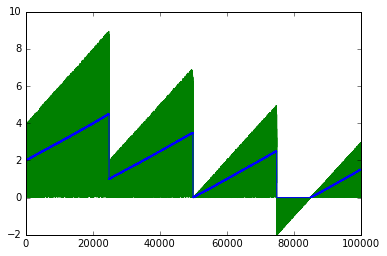

In [51]:
def sort(x, y, order):
    x = np.hstack((x, y.reshape(-1, 1)))
    x = np.sort(
        x.view(','.join(map(lambda i: 'f8', range(x.shape[1])))), 
        order=list(map(lambda a: 'f' + str(a), order)), 
        axis=0).view(float)
    y = x[:,x.shape[1] - 1]
    x = x[:,0:x.shape[1] - 1]
    return x, y

# Plot sales probability model
X_test, Y_test = generate_train_data(1000)
# X_test, Y_test = sort(X_test, Y_test, [0, 4])
# plt.scatter(np.arange(0, X_test.shape[0]), X_test[:, 0], color='black')
# plt.plot(np.arange(0, X_test.shape[0]), Y_test, color='green', linewidth=1)
# plt.plot(np.arange(0, X_test.shape[0]), sales_model(X_test), color='blue', linewidth=1)

# plt.show()

X_test, Y_test = sort(X_test, Y_test, [0, 3])
plt.plot(np.arange(0, X_test.shape[0]), Y_test, color='green', linewidth=1)
plt.plot(np.arange(0, X_test.shape[0]), sales_model(X_test), color='blue', linewidth=1)

plt.show()

In [6]:
def timeit(func):
    start = time.clock()
    func()
    end = time.clock()
    print(end - start, 's')
    
def plot(po, t, n):
    po.run(t, n)
    for i_n in range(1, n + 1):
        n_data = []
        for i_t in range(1, t + 1):
            n_data.append(po.run(i_t, i_n)[0])
        if i_n in [1, 2, 3, 4, 5, 10, 20, 30]:
            label_text = "N=" + str(i_n)
            plt.plot(n_data, label=label_text)
    plt.ylabel('n')
    plt.xlabel('t')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()
        
def make_price_optimizer(sales_model_coef, competitor_prices,
               T=20, N=15,
               price_range=np.arange(10, 20, 1), 
               L=0.01, delta=0.99, Z=0.5):
    po = PriceOptimizer_CPP(T, N)
    # po = PriceOptimizer_Python(sales_model_coef, competitor_prices, T, N)
    # po.make_X = make_X
    po.L = L
    po.Z = Z
    po.delta = delta
    po.price_range = price_range
    po.competitor_prices = competitor_prices
    po.sales_model_coef = sales_model_coef
    print(sales_model_coef)
    return po

In [7]:
def simulation(sales_model, competitor_prices, T=20, N=15, iterations=20):
    
    def sales_prob(price, t):
        x = make_X(price, competitor_prices, t).reshape(1, -1)
        return sales_model(x)[0]
    
    profits = []
    
    L=0.01
    Z=0.5

    optimizer = make_price_optimizer(sales_model_coef, competitor_prices, 
                               T=T, N=N, L=L, Z=Z, price_range=np.arange(10., 20., 0.2))
    
    timeit(lambda: plot(optimizer, T, N))
    
    for i in range(iterations):
        
        price_history = []
        accumulated_sales = []
    
        profit = 0
        n = N
        
        for t in range(0, T):
            price, V = optimizer.run(t, n)
            pi = sales_prob(price, t)
            sales = min(n, np.random.poisson(pi))
            # sales = min(n, np.random.binomial(M, pi))
            n = n - sales
            profit += price * sales - L * n

            price_history.append(price)
            accumulated_sales.append(N - n)

            # # Change competitor prices
            # competitor_prices = competitor_prices * np.random.uniform(0.8, 1.2, 5)
            # optimizer = PriceOptimizer(sales_model, competitor_prices, N=n, T=T, L=L, Z=Z)

        # Realize salvage profits
        profit += n * Z

        if i < 5:
            print("Estimated profit: {0}".format(optimizer.run(0, N)[1]))
            print("Simulated profit: {0}".format(profit))
            
            plt.plot(price_history)    
            plt.ylabel('Price Path')
            plt.show()

            plt.plot(accumulated_sales)    
            plt.ylabel('Accumulated Sales')
            plt.show()
        
        profits.append(profit)

    return profits

# competitor_prices_simulation = 16 + np.random.uniform(0, 4, 5)
# simulation(sales_model, competitor_prices_simulation)

[ 11.  13.  14.  16.  18.]
[ -1.54983542e-02   8.78557853e-03  -4.29048075e-04   7.45003178e-02
   6.31772100e-06  -2.52205967e-02   3.95489309e-03]


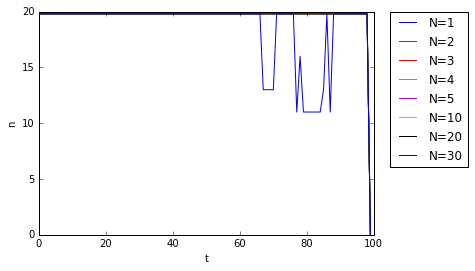

2.342829 s
Estimated profit: 1390.101427941073
Simulated profit: 795.2299999999998


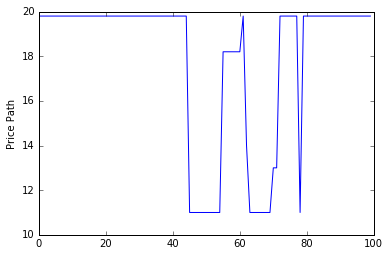

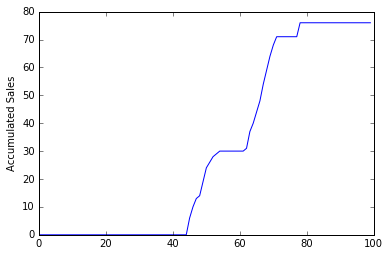

Estimated profit: 1390.101427941073
Simulated profit: 837.7199999999989


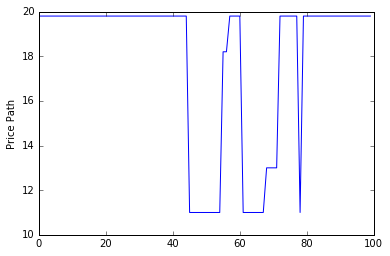

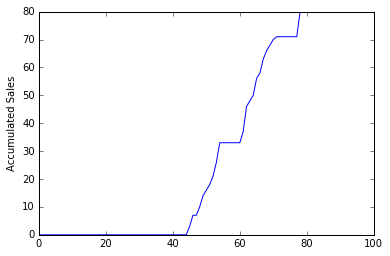

Estimated profit: 1390.101427941073
Simulated profit: 775.9100000000001


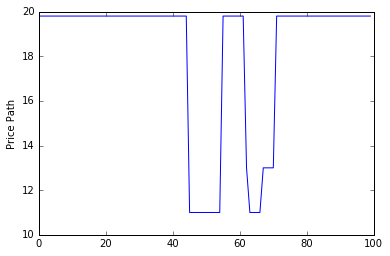

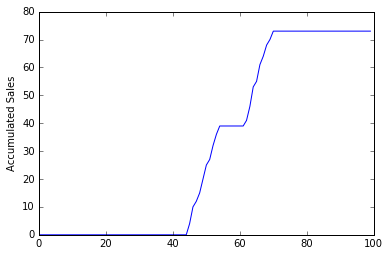

Estimated profit: 1390.101427941073
Simulated profit: 826.9599999999992


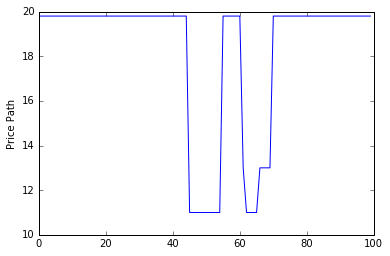

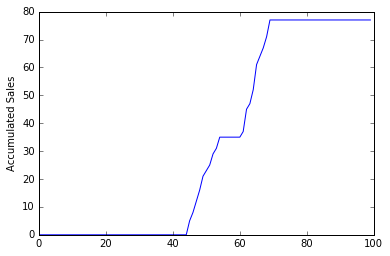

Estimated profit: 1390.101427941073
Simulated profit: 759.4000000000001


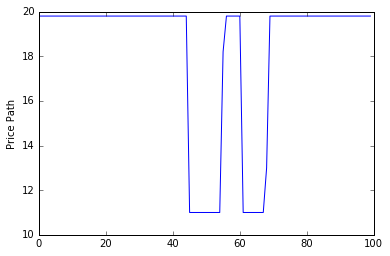

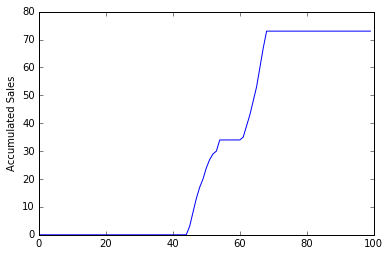

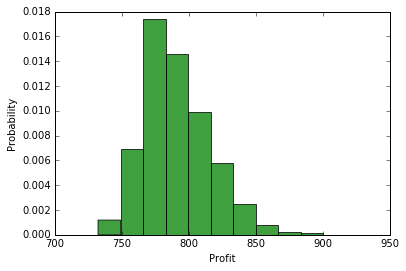

In [8]:
# competitor_prices = np.around(10 + np.random.uniform(0, 10, 5), decimals=2)
competitor_prices = np.array([11., 13., 14., 16., 18.])
print(competitor_prices)
profits = simulation(sales_model, competitor_prices, T=100, N=100, iterations=1000)
    
n, bins, patches = plt.hist(profits, 10, normed=1, facecolor='green', alpha=0.75)

plt.xlabel('Profit')
plt.ylabel('Probability')
plt.show()

[[-0.3550798  -0.76523941  0.73476059  0.4449202 ]]


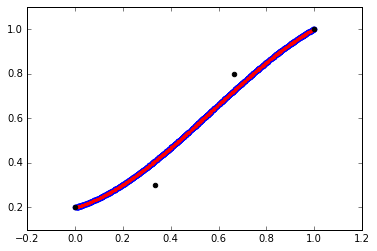

In [55]:
X2 = np.random.uniform(0, 1, (1000, 1))
X2_0 = (1 - X2) * (1 - X2) * (1 - X2)
X2_1 = X2 * (1 - X2) * (1 - X2)
X2_2 = X2 * X2 * (1 - X2)
X2_3 = X2 * X2 * X2
X2_ = np.hstack((X2_0, X2_1, X2_2, X2_3))
A = 0.2
B = 0.3
C = .8
D = 1
Y2 = A * X2_0 + B * 3 * X2_1 + C * 3* X2_2 + D * X2_3

regr2 = linear_model.LinearRegression()
regr2.fit(X2_, Y2)
print(regr2.coef_)

plt.scatter(X2, regr2.predict(X2_), color='blue')
plt.scatter(X2, Y2, color='red', s=3)
plt.scatter((0, 1/3, 2/3, 1), (A, B, C, D), color='black')
plt.show()

